In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Define a function to calculate the residual image by subtracting the reconstructed image from the original
def calculate_residual(original_path, reconstructed_path):
    # Read the original and reconstructed images
    original = cv2.imread(original_path, cv2.IMREAD_UNCHANGED)
    reconstructed = cv2.imread(reconstructed_path, cv2.IMREAD_UNCHANGED)
    
    # Convert images to float for accurate subtraction
    original_float = original.astype(np.float32)
    reconstructed_float = reconstructed.astype(np.float32)
    
    # Calculate the residual
    residual = original_float - reconstructed_float
    
    # Clip values to the range [0, 255] and convert to uint8
    residual_clipped = np.clip(residual, 0, 255).astype(np.uint8)
    
    return residual_clipped

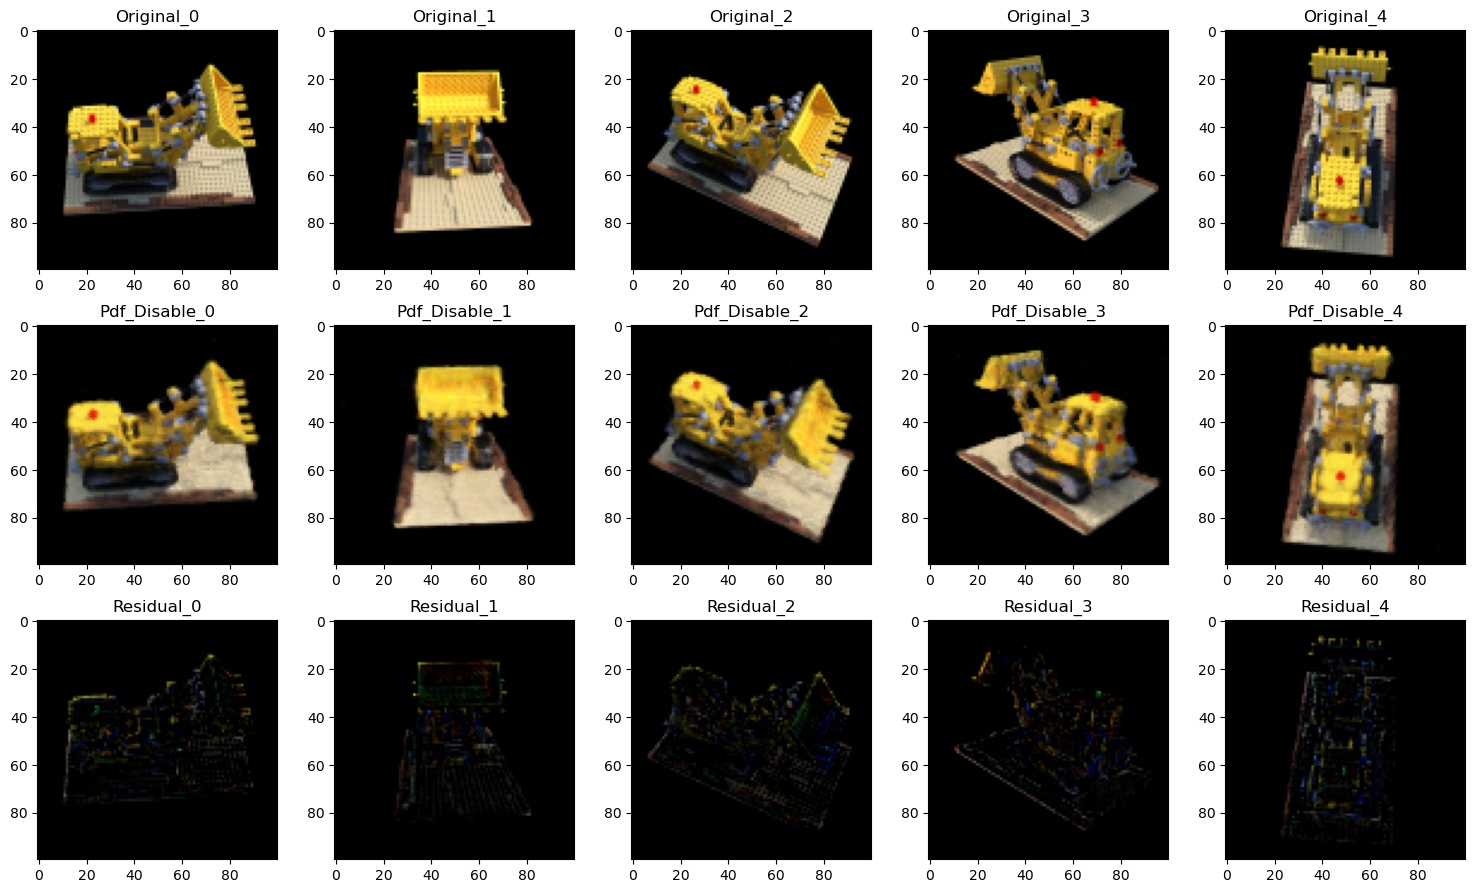

In [3]:
# Load the images
image_paths = [f'images/prediction_pdf_disable_{i}_51000.png' for i in range(20,25)]
images = [cv2.imread(i) for i in image_paths]

origin_paths = [f'images/original_pdf_disable_{i}_51000.png' for i in range(20,25)]
origin_images = [cv2.imread(i) for i in origin_paths]

residual_images = [calculate_residual(original_path,image_path) for original_path,image_path in zip(origin_paths,image_paths)]

fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i,image in enumerate(origin_images):
    axs[0,i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0,i].set_title(f"Original_{i}")
    
for i,image in enumerate(images):
    axs[1,i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[1,i].set_title(f"Pdf_Disable_{i}")
    
for i,image in enumerate(residual_images):
    axs[2,i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[2,i].set_title(f"Residual_{i}")
    
plt.tight_layout()

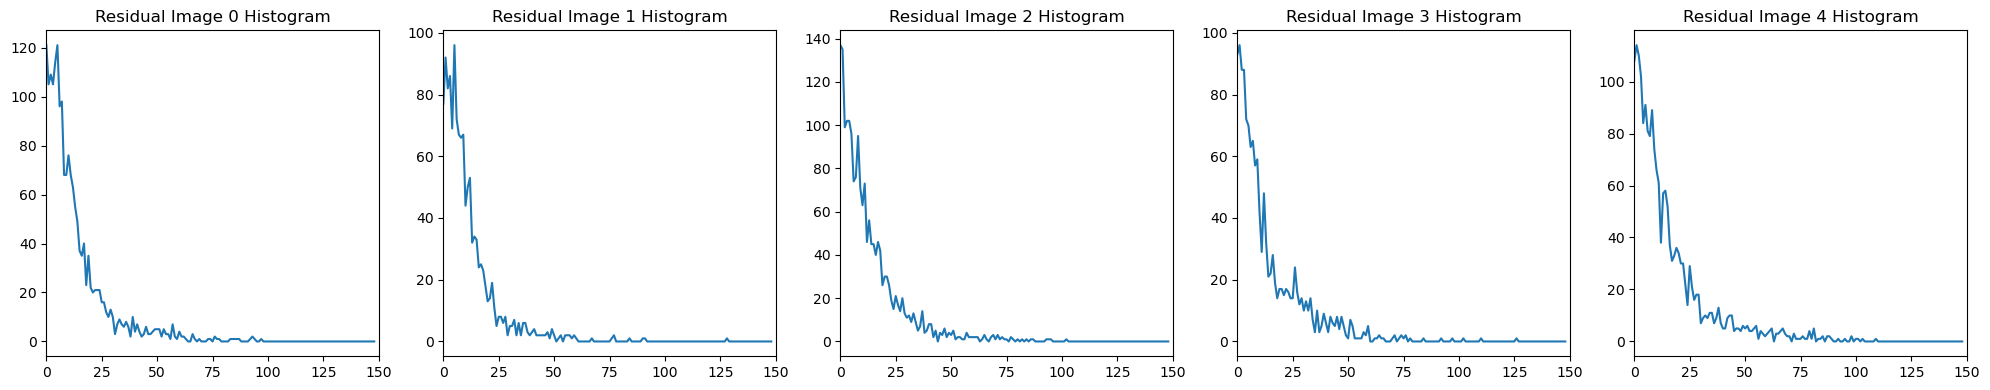

In [4]:
# Calculate the histograms of the images to observe the distribution of pixel intensities
histograms = []

for image in residual_images:
    # Calculate the histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist[1:150]
    histograms.append(hist)
    

# Plot the histograms
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, ax in enumerate(axes):
    ax.plot(histograms[i])
    ax.set_title(f'Residual Image {i} Histogram')
    ax.set_xlim([0, 150])

plt.tight_layout()
plt.show()

In [5]:
residual_paths = []
for i, residual in enumerate(residual_images):
    path = f'images/residual_pdf_disable_{i}_51000.png'
    cv2.imwrite(path, residual)
    residual_paths.append(path)

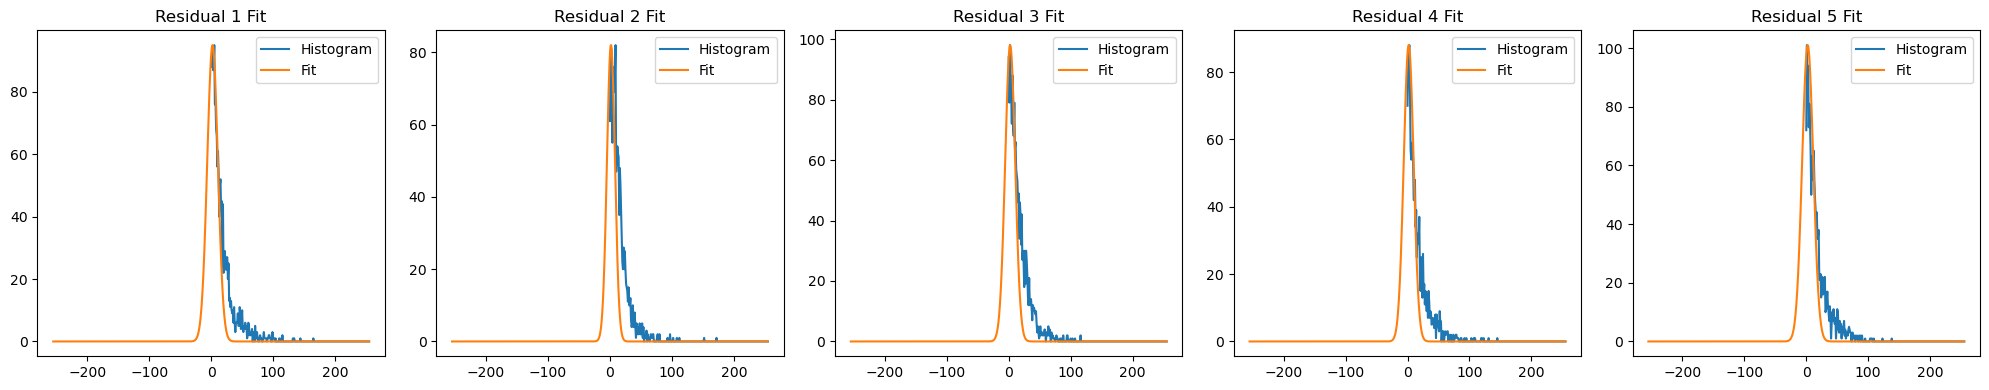

[(2.2, 8.6), (1.6, 6.5), (2.3, 8.1), (1.9, 8.0), (2.3, 9.0)]

In [6]:
# Function to analyze the distribution of the residuals
def analyze_residuals(residual_path):
    # Read the residual image
    residual = cv2.imread(residual_path, cv2.IMREAD_UNCHANGED)
    # Flatten the residual image to 1D array for statistical analysis
    residual_flattened = residual.flatten()
    # Calculate histogram of the residuals
    hist = cv2.calcHist([residual], [1], None, [256], [1, 256])
    return residual_flattened, hist

# Initialize lists to store analysis results
residual_data = []
histograms = []

# Analyze each residual image
for path in residual_paths:
    data, hist = analyze_residuals(path)
    residual_data.append(data)
    histograms.append(hist)

# Fit a normal distribution to the residuals
from scipy.stats import norm

# Parameters to store fitted distribution parameters
fitted_params = []

for data in residual_data:
    # Fit a normal distribution to the data
    mu, std = norm.fit(data)
    fitted_params.append((np.round(mu,1), np.round(std,1)))

# Plot the histograms and the fitted distributions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

x = np.linspace(-255, 255, 1000)  # Range for plotting the fitted normal distributions

for i, ax in enumerate(axes):
    # Plot the histogram
    ax.plot(histograms[i], label='Histogram')
    # Plot the fitted distribution
    p = norm.pdf(x, fitted_params[i][0], fitted_params[i][1])
    ax.plot(x, p * np.max(histograms[i]) / np.max(p), label='Fit')  # Scale fitted line to histogram height
    ax.set_title(f'Residual {i+1} Fit')
    ax.legend()

plt.tight_layout()
plt.show()

# Output the fitted distribution parameters
fitted_params

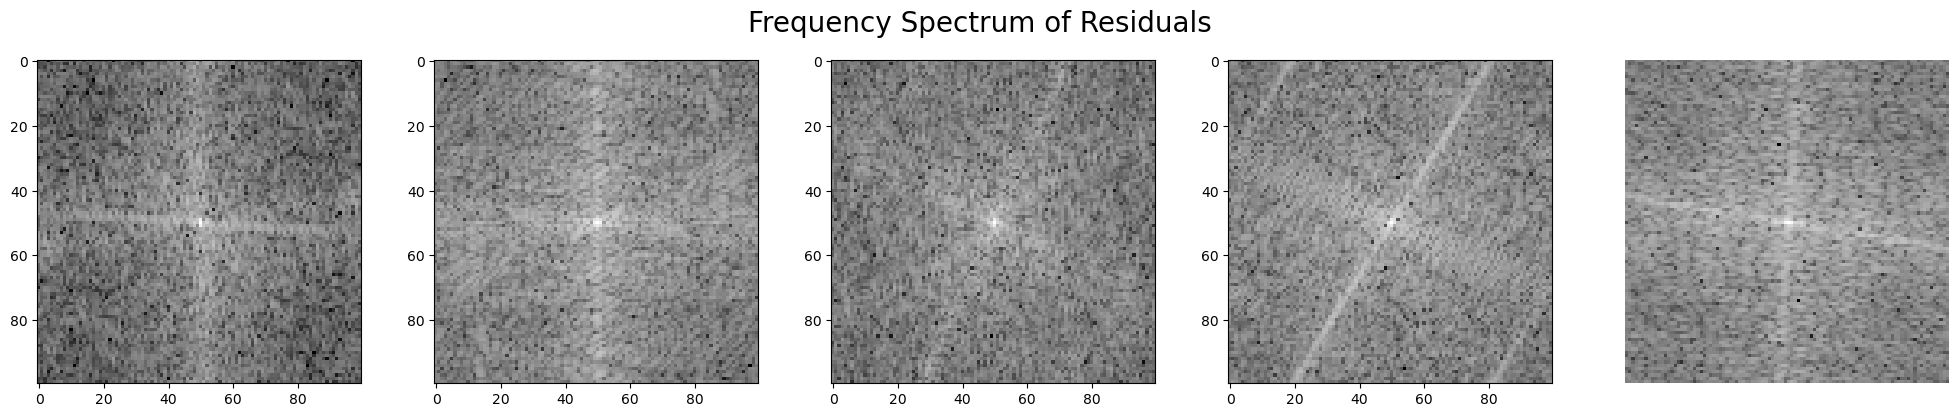

In [7]:
from skimage.feature import graycomatrix, graycoprops
from numpy.fft import fft2, fftshift

residual_paths = []
for i, residual in enumerate(residual_images):
    path = f'images/residual_pdf_disable_{i}_51000.png'
    cv2.imwrite(path, residual)
    residual_paths.append(path)

# Function to calculate the frequency spectrum of an image using Fourier Transform
def calculate_frequency_spectrum(image):
    f = fft2(image)
    fshift = fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift))
    return magnitude_spectrum


# Choose one of the residual images to analyze

residual_images = [cv2.imread(residual_image_path, cv2.IMREAD_GRAYSCALE) for residual_image_path in residual_paths]

# Calculate frequency spectrum
frequency_spectrum = [calculate_frequency_spectrum(residual_image) for residual_image in residual_images]


# Plot the histograms and the fitted distributions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
# Plot the frequency spectrum
for i, ax in enumerate(axes):
    # Plot the histogram
    ax.imshow(frequency_spectrum[i], cmap = "gray")

plt.suptitle('Frequency Spectrum of Residuals',fontsize = 20)
plt.axis('off')
plt.tight_layout()
plt.show()


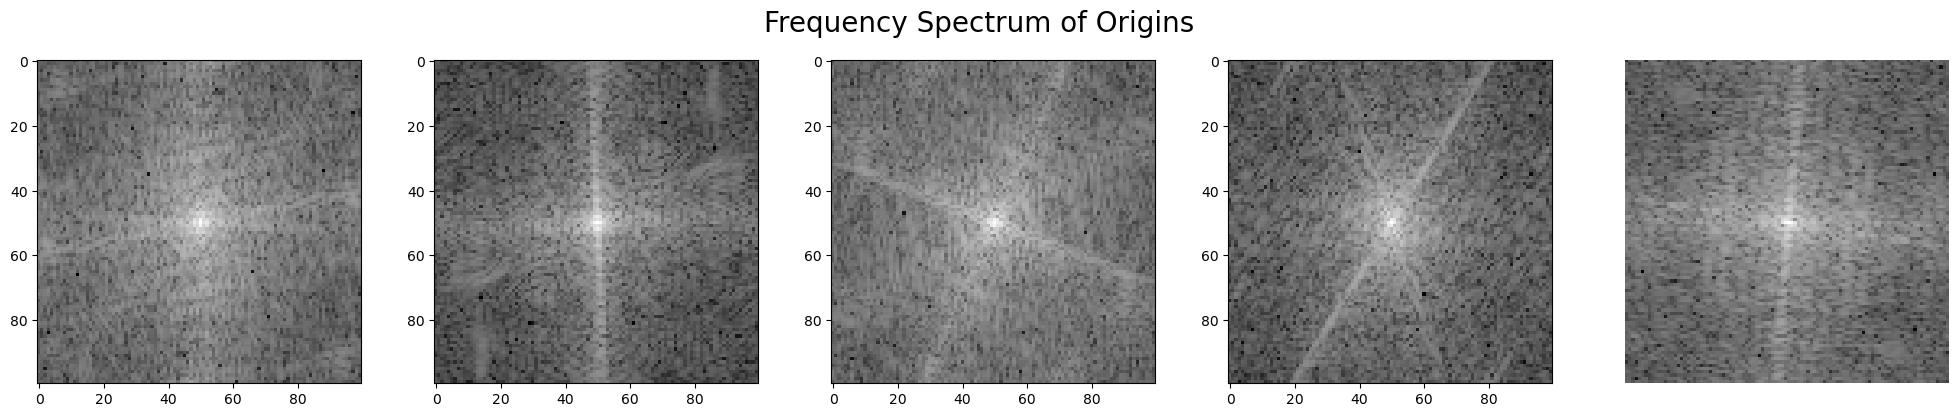

In [8]:
# Calculate frequency spectrum
frequency_spectrum = [calculate_frequency_spectrum(origin_image) for origin_image in [cv2.imread(i, cv2.IMREAD_GRAYSCALE) for i in origin_paths]]


# Plot the histograms and the fitted distributions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
# Plot the frequency spectrum
for i, ax in enumerate(axes):
    # Plot the histogram
    ax.imshow(frequency_spectrum[i], cmap = "gray")

plt.suptitle('Frequency Spectrum of Origins',fontsize = 20)
plt.axis('off')
plt.tight_layout()
plt.show()


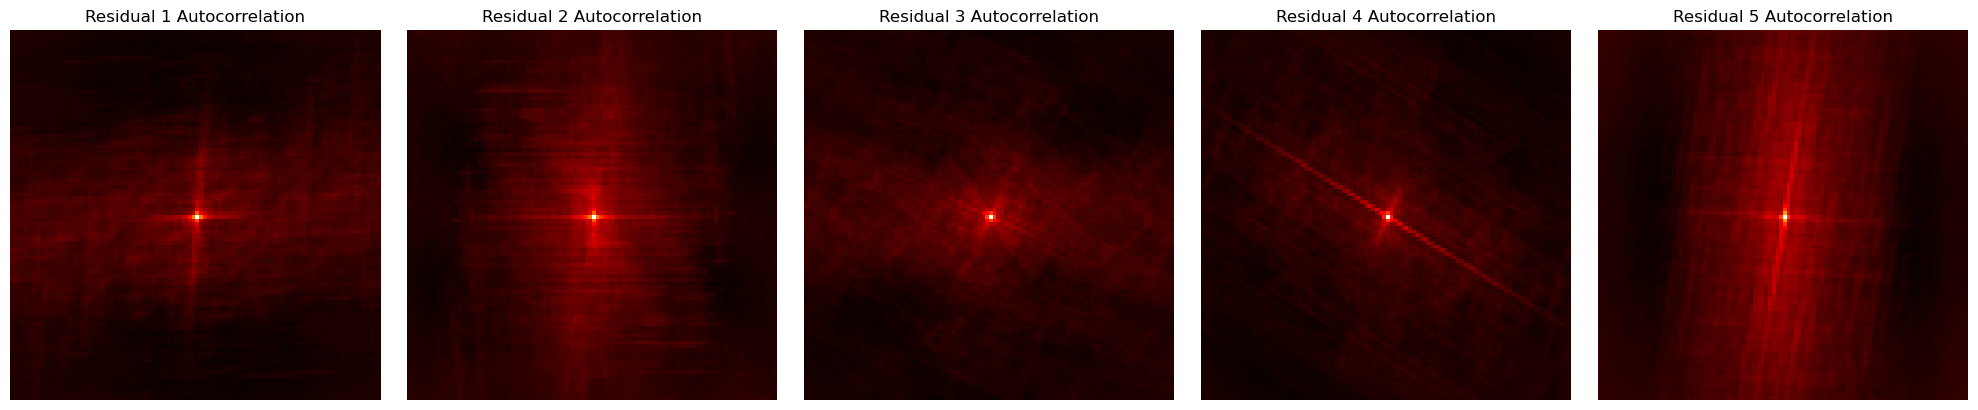

In [9]:
from scipy.signal import correlate2d

# Function to calculate 2D autocorrelation of an image
def calculate_autocorrelation(image):
    # Normalize image
    image_normalized = image - np.mean(image)
    # Calculate autocorrelation using correlate2d
    autocorr = correlate2d(image_normalized, image_normalized, mode='full')
    # Normalize autocorrelation by the maximum value to bring the values between [0, 1]
    autocorr_normalized = autocorr / np.max(autocorr)
    return autocorr_normalized

# Calculate 2D autocorrelation for each residual image
autocorrelations = [calculate_autocorrelation(cv2.imread(path, cv2.IMREAD_GRAYSCALE)) for path in residual_paths]

# Plot the 2D autocorrelation for each residual image
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    # Select the central part of the autocorrelation for display
    center = tuple(map(lambda x: x // 2, autocorrelations[i].shape))
    extent = 50  # We will display a 50x50 region around the center
    autocorr_display = autocorrelations[i][
        center[0]-extent:center[0]+extent, 
        center[1]-extent:center[1]+extent
    ]
    ax.imshow(autocorr_display, cmap='hot')
    ax.axis('off')
    ax.set_title(f'Residual {i+1} Autocorrelation')
    

plt.tight_layout()
plt.show()

In [10]:
from skimage import io, color, measure, draw, img_as_bool
from scipy import ndimage
import math

# Function to analyze a single spectrum image and find the direction of the white light
def analyze_spectrum(spectrum):
    # Threshold the image to get the bright regions
    thresh = spectrum > (np.mean(spectrum) + 7 * np.std(spectrum))
    plt.axis('off')
    plt.imshow(thresh)
    plt.savefig("Autocorrelation24.jpg",dpi=300)
    
    # Label the regions
    labeled, num_features = ndimage.label(thresh)
    if num_features == 0:
        return None  # Return None if no features are found after thresholding
    
    # Calculate the centroid of the bright regions
    centroid = ndimage.center_of_mass(thresh, labeled, range(1, num_features+1))
    
    # If no bright region is detected, return None
    if not centroid:
        return None
    
    # Since we expect a single bright region, we take the first and only centroid
    cy, cx = (100,100)

    
    # Use the centroid coordinates to calculate the angle of the bright region
    # In a frequency spectrum, the angle of the bright line corresponds to the angle of the image feature
    angle = np.arctan2(cy - spectrum.shape[0] / 2, cx - spectrum.shape[1] / 2)
    angle_degrees = np.degrees(angle)
    
    # Normalize the angle to a value between 0 and 180 degrees
    normalized_angle = angle_degrees % 180
    
    return normalized_angle

45.0

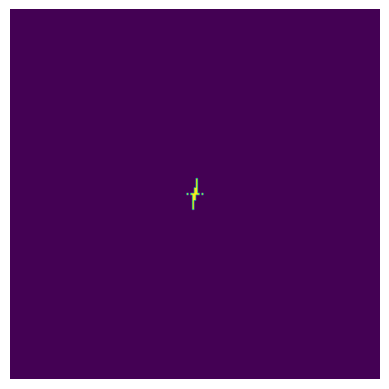

In [11]:
analyze_spectrum(autocorrelations[4])

In [12]:
print(autocorrelations[0].shape)

(199, 199)


## New Way to find Spectrum

array([[4.52178858, 6.44699509, 6.4732104 , ..., 6.45286081, 6.4732104 ,
        6.44699509],
       [5.73369081, 6.33622118, 6.36984227, ..., 6.4309306 , 6.29169412,
        6.48103443],
       [6.82079751, 5.97884758, 6.23541775, ..., 5.9310714 , 5.36467619,
        6.49673848],
       ...,
       [7.22523669, 6.30185732, 5.70581927, ..., 6.537423  , 6.38184702,
        5.55235894],
       [6.82079751, 6.49673848, 5.36467619, ..., 6.24281142, 6.23541775,
        5.97884758],
       [5.73369081, 6.48103443, 6.29169412, ..., 6.52155517, 6.36984227,
        6.33622118]])

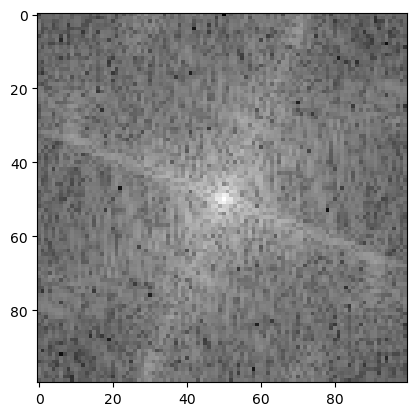

In [13]:
plt.imshow(frequency_spectrum[2], cmap = "gray")
frequency_spectrum[2]

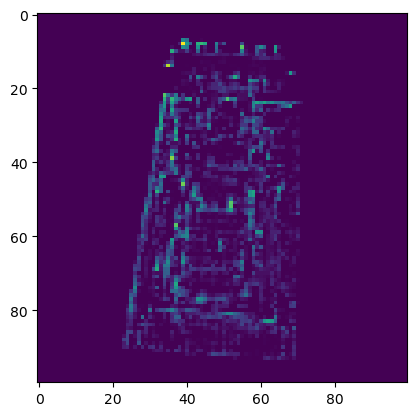

In [14]:
spectrum2 = frequency_spectrum[2]
spectrum2 = np.mean(image,axis=2)
plt.imshow(spectrum2)

In [16]:
import skimage.transform.hough_line

ModuleNotFoundError: No module named 'skimage.transform.hough_line'

In [20]:
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return int(x), int(y)

def detect(image):
    # some preprocessing
    thin = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    thin = cv2.blur(thin, (10, 10))
    _, thin = cv2.threshold(thin, 220, 255, 0)

    # thin image to find clear contours
    thin = cv2.ximgproc.thinning(thin, thinningType=cv2.ximgproc.THINNING_GUOHALL)

    # dind contours
    cnts = cv2.findContours(thin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv2.contourArea)

    # obtain outer coordinates
    left = tuple(c[c[:, :, 0].argmin()][0])
    right = tuple(c[c[:, :, 0].argmax()][0])
    top = tuple(c[c[:, :, 1].argmin()][0])
    bottom = tuple(c[c[:, :, 1].argmax()][0])

    # draw connecting line
    cv2.line(image, left, right, (0,0,255), 2)

    # find the point of intersection
    # b/w connecting lines and curve points
    l1 = line(left, right)
    l2 = line((bottom[0], top[1]), bottom)
    inter = intersection(l1, l2)

    # draw center curve intersection line
    cv2.line(image, inter, bottom, (255, 255, 0), 2)

    # draw line contours
    cv2.drawContours(image, [c], -1, (36, 255, 12), 2)

    return image



In [21]:
image = cv2.imread("Autocorrelation20cp.jpg")
output = detect(image)

ValueError: max() arg is an empty sequence

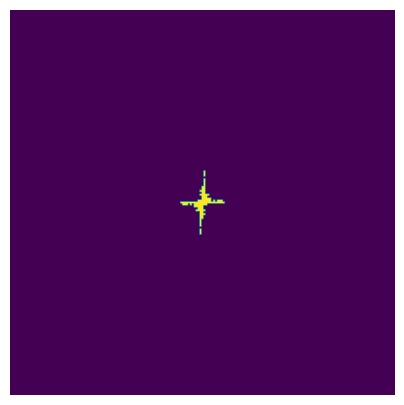

In [18]:
fig,ax = plt.subplots(figsize = (5,5))
ax.imshow(autocorrelations[0] > np.mean(autocorrelations[0]) + 5 * np.std(autocorrelations[0]))
plt.axis("off")
fig.savefig("Autocorrelation20.jpg",dpi = 300)

In [58]:
import numpy as np

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

from pylab import imread, imshow, gray, mean

import matplotlib.pyplot as plt
from matplotlib import cm

image = imread('Autocorrelation20cp.jpg')
image = np.mean(image,axis=2)
image = (image < 50.334)*255



In [53]:
for row in range(image.shape[0]):
    for c in range(image.shape[1]):
        if image[row,c] >0:
            image[row,c] = 0

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [59]:
image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

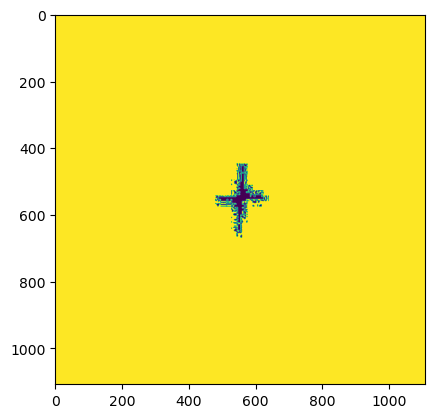

In [60]:
plt.imshow(image)

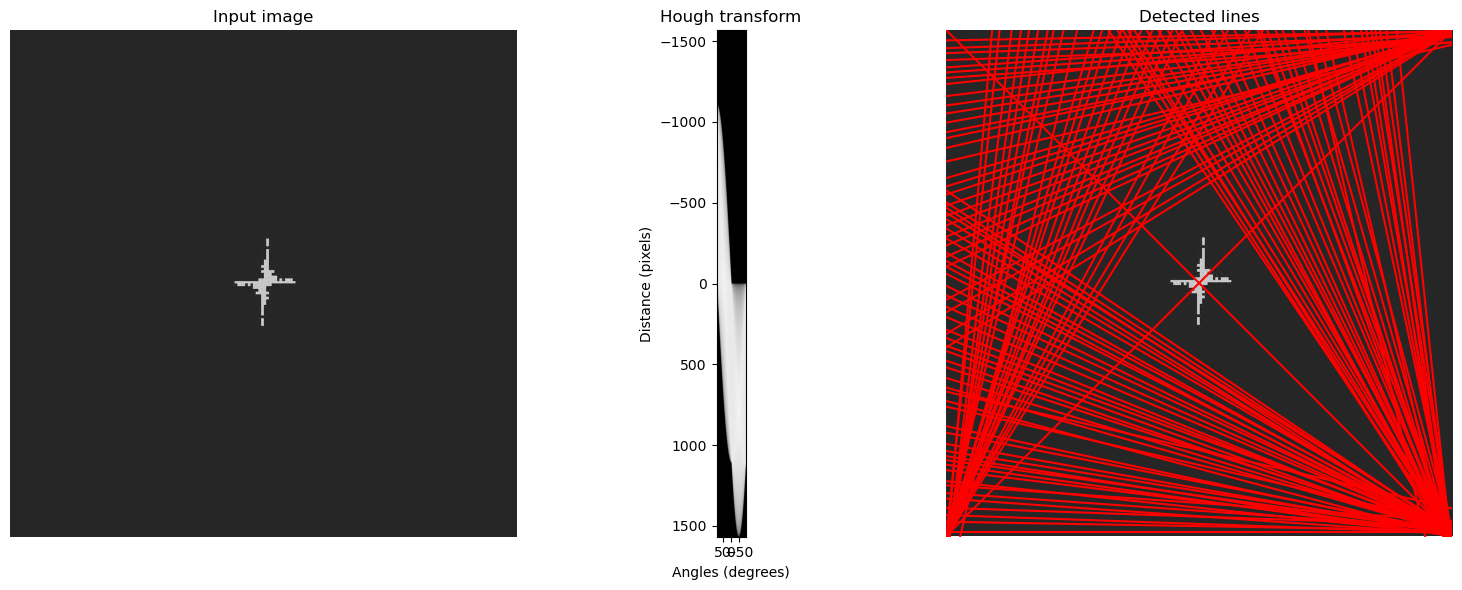

In [57]:
h, theta, d = hough_line(image)

fig, axes = plt.subplots(1, 3, figsize=(15, 6),
                         subplot_kw={'adjustable': 'box'})
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()
ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

angle=[]
dist=[]
for _, a , d in zip(*hough_line_peaks(h, theta, d)):
    angle.append(a)
    dist.append(d)

angle = [a*180/np.pi for a in angle]
angle_reel = np.max(angle) - np.min(angle)